# Transfer Learning - Scaling Up

In [1]:
# Importing TF and checking the version
import tensorflow as tf

print(tf.__version__)

2.10.1


In [2]:
# Importing custom helper functions
from DanielBourke_HelperFunctions import create_tensorboard_callback, plot_loss_curves, compare_historys, walk_through_dir

In [3]:
# Setting data directories
train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

In [4]:
# How many images are we dealing with
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent\test'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\apple_pie'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\baby_back_ribs'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\baklava'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\beef_carpaccio'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\beef_tartare'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\beet_salad'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\beignets'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\bibimbap'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\bread_pudding'.
There are 0 directories and 250 images in '10

In [5]:
# Setting up data inputs
IMG_SIZE = (224, 224)

train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    label_mode="categorical",
    image_size=IMG_SIZE
)

test_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode="categorical",
    image_size=IMG_SIZE,
    shuffle=False # Don't shuffle test data
)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [6]:
# Creating checkpoint callback
checkpoint_path = "101_food_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    save_weights_only=True,
    monitor="val_accuracy",
    save_best_only=True
)

In [7]:
# Creating data augmentation
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2)
    # preprocessing.Rescaling(1./255) - for models, that don't auto-rescale
], name="data_augmentation")

In [8]:
# Setting up the base model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setting up layers
inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = layers.Dense(
    len(train_data_all_10_percent.class_names),
    activation="softmax",
    name="output_layer"
)(x)
model = tf.keras.Model(inputs, outputs)

In [9]:
# Getting the model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [10]:
# Compiling the model
model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

# Fitting the model
history = model.fit(
    train_data_all_10_percent,
    epochs=5,
    steps_per_epoch=len(train_data_all_10_percent),
    validation_data=test_data_all_10_percent,
    validation_steps=int(0.25 * len(test_data_all_10_percent)),
    callbacks=[checkpoint_callback]
)

Epoch 1/5
237/237 [==============================] - 1154s 5s/step - loss: 3.3958 - accuracy: 0.2698 - val_loss: 2.4634 - val_accuracy: 0.4392
Epoch 2/5
237/237 [==============================] - 548s 2s/step - loss: 2.1927 - accuracy: 0.4978 - val_loss: 2.0066 - val_accuracy: 0.5089
Epoch 3/5
237/237 [==============================] - 460s 2s/step - loss: 1.8362 - accuracy: 0.5632 - val_loss: 1.8224 - val_accuracy: 0.5409
Epoch 4/5
237/237 [==============================] - 459s 2s/step - loss: 1.6060 - accuracy: 0.6100 - val_loss: 1.7553 - val_accuracy: 0.5455
Epoch 5/5
237/237 [==============================] - 471s 2s/step - loss: 1.4496 - accuracy: 0.6426 - val_loss: 1.6992 - val_accuracy: 0.5558


In [11]:
# Evaluating on the whole dataset
feature_extraction_results = model.evaluate(test_data_all_10_percent)
feature_extraction_results

790/790 [==============================] - 1043s 1s/step - loss: 1.5845 - accuracy: 0.5823


[1.5845329761505127, 0.5822970271110535]

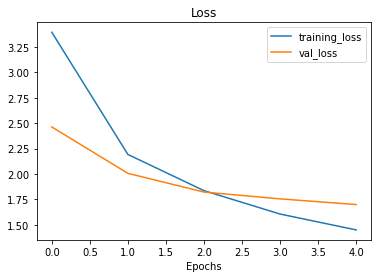

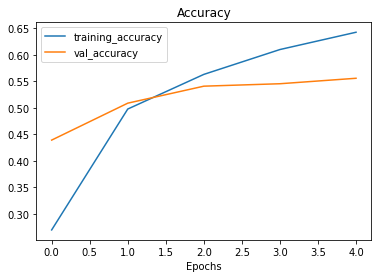

In [12]:
# Visualising the loss curves
plot_loss_curves(history=history)

### Fine-Tuning

In [13]:
# Unfreeze all layers
base_model.trainable = True

# Refreeze all layers except for the last 5
for layer in base_model.layers[:-5]:
    layer.trainable = False

In [18]:
# Recompiling the model with a lower learning rate
model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=["accuracy"]
)

In [19]:
# Checking which layers are trainable
for layer in model.layers:
    print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_average_pooling_layer True
output_layer True


In [20]:
# Checking which layers are trainable in the base model
for layer_number, layer in enumerate(model.layers[2].layers):
    print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze False
39

In [21]:
# Fine-tune for 5 more epochs
fine_tune_epochs = 10

history_finetuned = model.fit(
    train_data_all_10_percent,
    epochs=fine_tune_epochs,
    steps_per_epoch=len(train_data_all_10_percent),
    validation_data=test_data_all_10_percent,
    validation_steps=int(0.15 * len(test_data_all_10_percent)),
    initial_epoch=history.epoch[-1]
)

Epoch 5/10
  9/237 [>.............................] - ETA: 3:54 - loss: 1.1982 - accuracy: 0.7292

In [ ]:
# Evaluating on the whole test dataset
fine_tuning_results = model.evaluate(test_data_all_10_percent)
fine_tuning_results

In [ ]:
# Comparing histories
compare_historys(
    original_history=feature_extraction_results,
    new_history=fine_tuning_results,
    initial_epochs=5
)